<a href="https://colab.research.google.com/github/shoreey/Ovarian-Cancer-Prediction-with-Computer-Vision-Using-CNN/blob/main/Ovarian_Cancer_Prediction_with_Computer_vision_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import io
import pandas as pd
import random
import scipy.io as sio
from scipy import ndimage
import scipy
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

import torch
import torch.nn as nn
import math
from functools import partial
from torch.autograd import Variable

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import datetime
import copy

from PIL import Image

In [ ]:
BASE_DIR='D:\Data Science\Machine Learning\Data'
data_df = pd.read_excel('D:\Data Science\Machine Learning\Database_AI.xlsx')
data_df["Class"]=data_df["Surgical outcome"]>0

data_df.head()

,Filename,Data di nascita Paziente,Istologia,Grading,FIGO stage,BRCA,ECOG Performance Status,ca125 (numero intero),he4 (numero intero),ca 15.3 (numero intero),...,IDS,Data IDS,RT IDS,Recidiva,Data recidiva,Ultimo follow-up,Morte,Data morte,Surgical outcome,Class
0,34918138,1962-03-04,Carcinoma Sieroso Alto Grado,3.0,III b,VUS,0.0,963,NaN,NaN,...,NaN,NaT,NaN,No,NaT,2022-03-09 00:00:00,NaN,NaT,0,False
1,56770587,1962-01-15,Altri carcinomi ovarici,NaN,I,NaN,0.0,70,95.0,37.0,...,NaN,NaT,NaN,No,NaT,2022-01-24 00:00:00,No,NaT,0,False
2,79692917,1951-12-01,Carcinoma Sieroso Alto Grado,3.0,III c,non mutata,1.0,236,996.0,NaN,...,No,NaT,NaN,No,NaT,2021-12-23 00:00:00,No,NaT,0,False
3,86250014,1970-08-15,Carcinoma Sieroso Alto Grado,3.0,III c,non mutata,0.0,1228,NaN,74.0,...,No,NaT,NaN,Si,2021-10-27,2022-03-02 00:00:00,No,NaT,1,True
4,103336863,1954-09-19,Carcinoma Sieroso Alto Grado,3.0,IV,non mutata,0.0,2709,387.0,NaN,...,Si,2020-06-16,NaN,Si,2021-05-19,2021-11-30 00:00:00,No,NaT,1,True


In [ ]:
print (len(data_df))

192


In [ ]:
class OC_Dataset(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        self.transforms=transforms

    def __getitem__(self,index):
        #Load data corresponding to the row "index"

        # Use the patient ID as image name
        filename=str(self.df.iloc[index]['Filename']);
        # Create the correct path for the image to be loaded
        im_path=os.path.join(self.imfolder,filename.strip())

        # Load the data. If they are .mat files use loadmat, otherwise use
        # the needed loading function
        # In this case they are 3D grayscale volumetric data, that will be
        # stored into a tensor 1 x Height x Width x Depth
        data = sio.loadmat(im_path)
        x = data['V'].astype(np.float32)
        x = transforms.ToTensor()(x)
        x=x.unsqueeze(0).type(torch.FloatTensor);

        if(self.train):
            if(self.transforms):
                x=self.transforms(x)


        if(self.train):
            # During training, for each video the Dataset returns
            #  - a volume x
            #  - the outcome y:
            y=self.df.iloc[index]['Class']
            return x,y
        else:
            # During testing, only the volume is returned
            return x

    def __len__(self):
        return len(self.df)

In [ ]:
train, valid = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df.Class.values
)



# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.Class.values

# targets for validation
valid_targets = valid.Class.values

train_dataset=OC_Dataset(
    df=train,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

valid_dataset=OC_Dataset(
    df=valid,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    #num_workers=4,
    shuffle=False,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    #num_workers=4,
    shuffle=False,
)

In [ ]:
x,y = next(iter(train_loader))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for input_data, input_labels in train_loader:
    input_labels = input_labels.to(device)
    input_data=input_data.to(device)

In [ ]:
class Simple_CNN(nn.Module):

    def __init__(self, num_classes):


        super(Simple_CNN, self).__init__()

        self.conv_layer1 = self._make_conv_layer(1, 16)
        self.conv_layer2 = self._make_conv_layer(16, 32)
        self.conv_layer3 = self._make_conv_layer(32, 64)
        self.conv_layer4 = self._make_conv_layer(64, 128)
        #self.conv_layer5 = self._make_conv_layer(128, 64)

        self.fc1 = nn.Linear(1152, 128)
        #self.fc2 = nn.Linear(1024, 512)
        self.relu = nn.LeakyReLU()

        self.drop=nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(128, num_classes)

    def _make_conv_layer(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_c),
        #nn.ELU(),
        nn.LeakyReLU(),
        #nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
        #nn.LeakyReLU(),
        nn.MaxPool3d(kernel_size=3, stride=3),
        )
        return conv_layer

    def forward(self, x):
        #print(x.size())
        x = self.conv_layer1(x)
        #print(x.size())
        x = self.conv_layer2(x)
        #print(x.size())
        x = self.conv_layer3(x)
        #print(x.size())
        x = self.conv_layer4(x)
        #print(x.size())
        #x=self.conv_layer5(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.fc1(x)
        x = self.relu(x)
        #print(x.size())
        #x = self.fc2(x)
        #x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)

        return x#,x1

In [ ]:
model = Simple_CNN(2)
input_data, input_labels = next(iter(train_loader))
#print(input_data.size())
#print(input_data.type())
output=model(input_data)
print(output.size())

torch.Size([1, 2])


In [ ]:
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            running_corrects_0 = 0.0
            running_corrects_1 = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels=labels.to(device)


                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #loss = criterion(outputs, labels.type(torch.LongTensor).unsqueeze(1).to(device))
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects.double()/len(datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# if GPU is available, use it, otherwise use CPU
device = torch.device("cuda")

datasets={'train':train_dataset,'valid':valid_dataset}
dataloaders={'train':train_loader,'valid':valid_loader}

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

#criterion=nn.CrossEntropyLoss(weight=class_weight.to(device))
criterion=nn.CrossEntropyLoss()
#criterion=nn.BCEWithLogitsLoss()

num_epochs=100

trained_model=train_model(datasets,dataloaders,model,criterion,optimizer,scheduler,num_epochs,device)

Epoch 0/99
----------
train Loss: 0.7124 Acc: 0.6536
valid Loss: 0.6765 Acc: 0.5641

Epoch 1/99
----------
train Loss: 0.6538 Acc: 0.6536
valid Loss: 0.6707 Acc: 0.5897

Epoch 2/99
----------
train Loss: 0.6133 Acc: 0.6732
valid Loss: 0.6512 Acc: 0.5641

Epoch 3/99
----------
train Loss: 0.5739 Acc: 0.6863
valid Loss: 0.6135 Acc: 0.7436

Epoch 4/99
----------
train Loss: 0.5080 Acc: 0.7386
valid Loss: 0.6019 Acc: 0.7179

Epoch 5/99
----------
train Loss: 0.4645 Acc: 0.7451
valid Loss: 0.5696 Acc: 0.7179

Epoch 6/99
----------
train Loss: 0.3977 Acc: 0.7974
valid Loss: 0.5854 Acc: 0.7436

Epoch 7/99
----------
train Loss: 0.3332 Acc: 0.8431
valid Loss: 0.5804 Acc: 0.7179

Epoch 8/99
----------
train Loss: 0.2328 Acc: 0.9085
valid Loss: 0.5853 Acc: 0.7692

Epoch 9/99
----------
train Loss: 0.1612 Acc: 0.9739
valid Loss: 0.6123 Acc: 0.7436

Epoch 10/99
----------
train Loss: 0.1015 Acc: 0.9869
valid Loss: 0.6457 Acc: 0.7179

Epoch 11/99
----------
train Loss: 0.1137 Acc: 0.9739
valid Loss

In [ ]:
from sklearn.metrics import confusion_matrix

trained_model=trained_model.to(torch.device("cpu"))

res=np.array([])
lab=np.array([])

for inputs, labels in valid_loader:
    inputs = inputs
    labels=labels

    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)

    res=np.append(res,preds.numpy())
    lab=np.append(lab,labels.numpy())

In [ ]:
confusion_matrix(lab,res)

array([[23,  3],
       [ 5,  8]], dtype=int64)

In [ ]:
torch.save(model.state_dict(), 'Model_acc86')

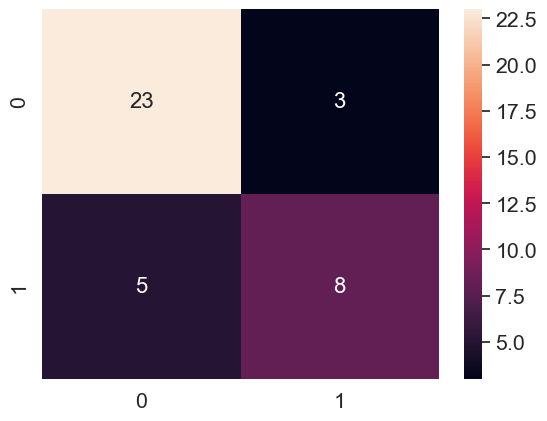

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

confusion_mat = confusion_matrix(lab,res)

df_cm = pd.DataFrame(confusion_mat, range(len(set(lab))), range(len(set(lab))))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()


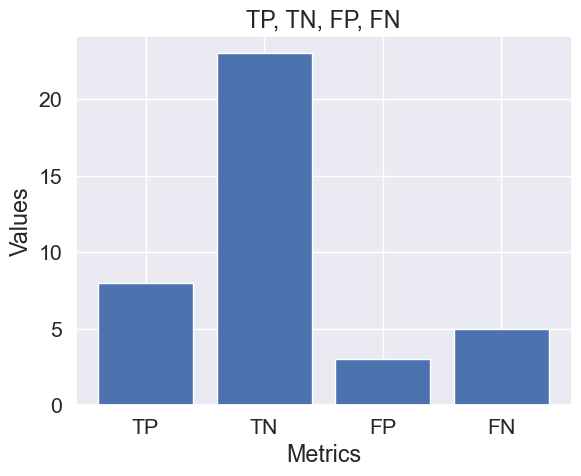

In [ ]:
import matplotlib.pyplot as plt

confusion_mat = confusion_matrix(lab,res)
tp = confusion_mat[1][1]
tn = confusion_mat[0][0]
fp = confusion_mat[0][1]
fn = confusion_mat[1][0]

plt.bar(['TP', 'TN', 'FP', 'FN'], [tp, tn, fp, fn])
plt.title("TP, TN, FP, FN")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.show()


# proportion of correctly classified instances out of all instances.

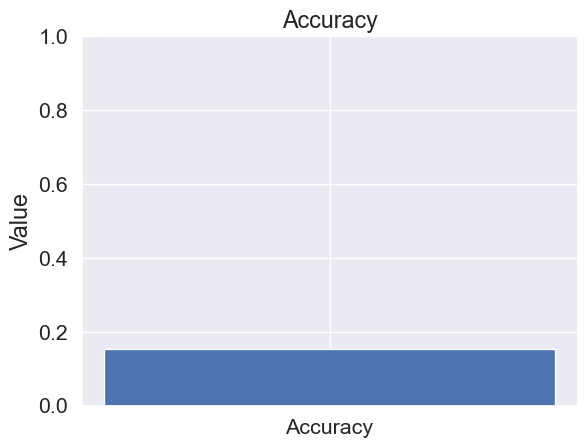

In [ ]:
6/(23+3+5+8)

accuracy = 6/(23+3+5+8)

plt.bar(['Accuracy'], [accuracy])
plt.title("Accuracy")
plt.ylim(0,1)
plt.ylabel("Value")
plt.show()

In [ ]:
TN=23
TP=8
FN=5
FP=3

PPV=TP/(TP+FP)
NPV=TN/(TN+FN)
print(PPV, NPV)

0.7272727272727273 0.8214285714285714


PPV:  0.7272727272727273
NPV:  0.8214285714285714


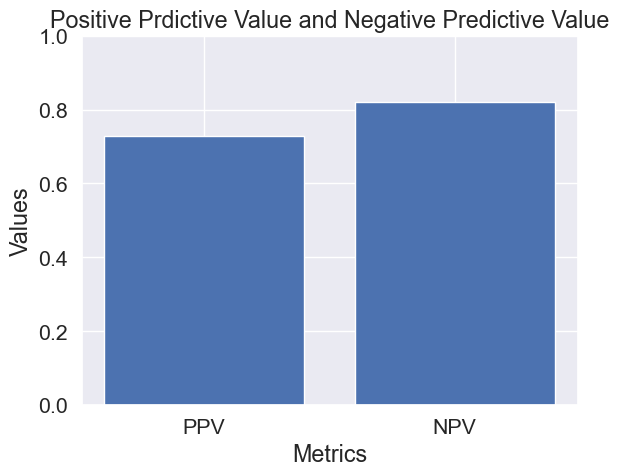

In [ ]:
import matplotlib.pyplot as plt

TN=23
TP=8
FN=5
FP=3

PPV = TP/(TP+FP)
NPV = TN/(TN+FN)

print("PPV: ", PPV)
print("NPV: ", NPV)

bar_data = [PPV, NPV]
bar_labels = ['PPV', 'NPV']
plt.bar(bar_labels, bar_data)
plt.title("Positive Prdictive Value and Negative Predictive Value")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.ylim(0,1)
plt.show()


# This measure indicates how many of the actual positive instances are correctly identified by the classifier

In [ ]:
8/13

0.6153846153846154

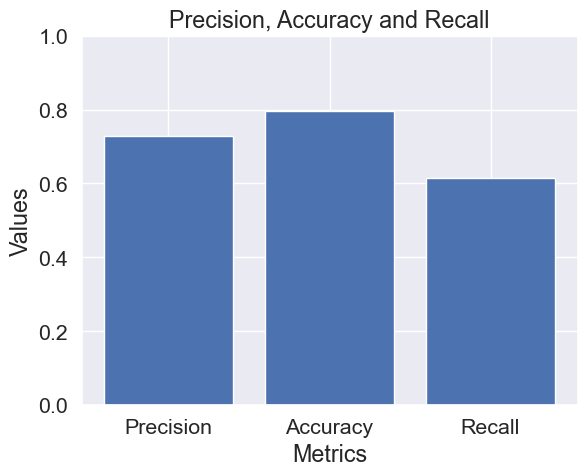

In [ ]:
import matplotlib.pyplot as plt

confusion_mat = confusion_matrix(lab,res)
tp = confusion_mat[1][1]
tn = confusion_mat[0][0]
fp = confusion_mat[0][1]
fn = confusion_mat[1][0]

precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fp+fn)
recall = tp/(tp+fn)

bar_data = [precision, accuracy, recall]
bar_labels = ['Precision', 'Accuracy', 'Recall']

plt.bar(bar_labels, bar_data)
plt.title("Precision, Accuracy and Recall")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.ylim(0,1)
plt.show()
